# CNN - Convolutional Neural Network Model
-----

## Set Up

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib
import math


In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

In [ ]:
# connect to google drive -> required for input image later
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [ ]:
X  = joblib.load( '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/X.pkl' )
y = joblib.load( '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/y.pkl' )

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=1)

In [ ]:
# Checking shape of data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (27701, 784)
y_train shape: (27701,)
X_val shape: (6926, 784)
y_val shape: (6926,)


## Utility Functions

In [ ]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

In [ ]:
unique_values, value_counts = np.unique(y, return_counts=True)

In [ ]:
def inspect_weights(model, layer_name):
  '''
    Overview:
    To get weights from a given layer.

    Arguments:
        - model: CNN model to inspect
        - layer_name: name of layer to access weights

    Output:
        - kernels (weights) as a 3x3 image
  '''
  layer = model.get_layer(layer_name)
  weights, baises = layer.get_weights()

  num_filters = weights.shape[-1]
  rows = math.ceil(num_filters/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))

  for i, ax in enumerate(axes.flatten()):
      if i < num_filters:
          ax.imshow(weights[:, :, 0, i], cmap='gray_r')
          ax.set_title(f'Filter {i+1}', fontsize=20)
          ax.set_xticks([])
          ax.set_yticks([])
      else:
          fig.delaxes(ax)  # Delete unused subplots

  plt.show()

In [ ]:
def get_letter_img (letter):
  letter_idx = alphabet.index(letter.lower())
  letter_image = X[y==letter_idx][0].reshape(28, 28)
  return letter_image

In [ ]:
def kernel_with_output(model,test_image, layer_name, filter=1):
  '''
    Overview:
    Visualizes the output of the specified layer and filter.

    Arguments:
        - model: A trained Keras model.
        - test_image: The input image to pass through the model.
        - layer_name: The name of the layer to be visualized.
        - filter: Filter to view.

    Output:
        - Outputs three figures:
            - Input image
            - Kernel/Filter (weights)
            - Output of filter after convolving the input image
  '''
  filter_pos = filter - 1

  weights, bias = model.get_layer(layer_name).get_weights()

  fig,axes = plt.subplots(1,3,figsize=(20, 10))

  axes[0].imshow(test_image,cmap='gray')
  axes[0].set_title(f'Input Image', fontsize = '30')
  axes[0].set_xticks([])
  axes[0].set_yticks([])

  # gray_r => now dark regions show "patterns" for each filter
  axes[1].imshow(weights[:,:,0,filter_pos], cmap='gray_r')
  axes[1].set_title(f'Filter {filter}', fontsize = '30')
  axes[1].set_xticks([])
  axes[1].set_yticks([])

  test_input = test_image.reshape(1, 28, 28, 1)

  # Redefine the model so the output is the after the provided layer
  output_conv = model.get_layer(layer_name).output
  conv_model = keras.Model(inputs= model.input, outputs = output_conv)
  pred = conv_model.predict(test_input)

  axes[2].imshow(pred[0,:,:,filter_pos], cmap='viridis')
  axes[2].set_title(f'Filter {filter} Output', fontsize = '30')
  axes[2].set_xticks([])
  axes[2].set_yticks([])

  plt.show()

In [ ]:
def get_conv_layer_ouput(model, layer_name, input_img):

  # force input_img shape to match model input shape
  input_img = input_img.reshape(1, 28, 28, 1)

  conv_model = keras.Model(inputs= model.input, outputs = model.get_layer(layer_name).output)
  output_conv = conv_model.predict(input_img)

  num_filters = output_conv.shape[-1]
  #output_conv[0,:,:,0] ->  results of first feature map when passed over the first filter

  rows = math.ceil(num_filters/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))
  ax = axes.flatten()

  for i in range(num_filters):
    ax[i].imshow(output_conv[0,:,:,i], cmap='viridis')
    ax[i].set_title(f'Filter {i+1} Output', fontsize = '20')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  plt.show()


## Defining input layer (KERAS)

In [ ]:
# Each sample is 28 by 28 image with 1 color channel, each batch size is not fixed
img_inputs = keras.Input(shape = (28, 28, 1))

In [ ]:
# Checking shape of my_inputs
# None = placeholder for batch size
img_inputs.shape

TensorShape([None, 28, 28, 1])

In [ ]:
# Checking dtype of my_inputs
img_inputs.dtype

tf.float32


## Creating my hidden layers

In [ ]:
# Passing inputs and setting up hidden layer 'steps'
hidden_l1 = Conv2D(32, (3, 3), activation='relu', name='conv_layer_1')(img_inputs)
hidden_l1 = BatchNormalization()(hidden_l1)
hidden_l1 = MaxPooling2D((2, 2))(hidden_l1)
hidden_l1 = Dropout(0.25)(hidden_l1)


In [ ]:
# Checking layer output
hidden_l1

<KerasTensor: shape=(None, 13, 13, 32) dtype=float32 (created by layer 'dropout')>

In [ ]:
# Passing inputs and setting up hidden layer 'steps'
hidden_l2 = Conv2D(64, (3, 3), activation='relu', name='conv_layer_2')(hidden_l1)
hidden_l2 = BatchNormalization()(hidden_l2)
hidden_l2 = MaxPooling2D((2, 2))(hidden_l2)
hidden_l2 = Dropout(0.25)(hidden_l2)


In [ ]:
# Checking layer output
hidden_l2

<KerasTensor: shape=(None, 5, 5, 64) dtype=float32 (created by layer 'dropout_1')>

## Creating output layer

In [ ]:
num_classes = np.unique(y_train).shape

In [ ]:
# Flatten into 1d for dense layers
output_layer = layers.Dense(128, activation="relu")(Flatten()(hidden_l2))
output_layer = layers.Dense(64, activation="relu")(output_layer)
output_layer = layers.Dense(num_classes[0], activation="softmax")(output_layer)

In [ ]:
output_layer

<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'dense_2')>

## Creating the model

In [ ]:
# Defining my model
my_model = keras.Model(inputs=img_inputs, outputs = output_layer, name = 'my_sign_lang_model')

In [ ]:
my_model.summary()

Model: "my_sign_lang_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 11, 11, 64) 

## Plotting my model

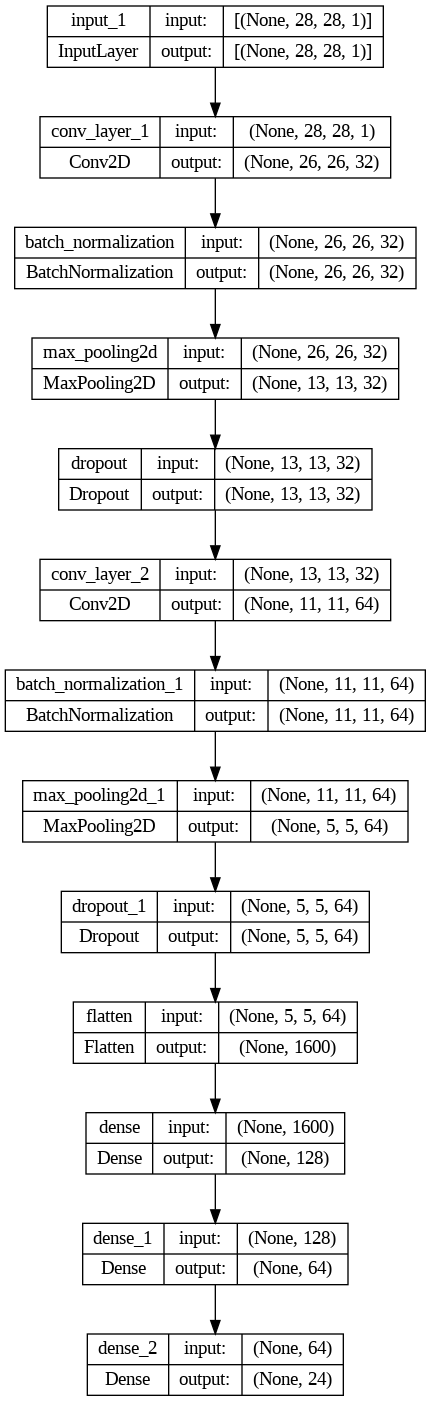

In [ ]:
keras.utils.plot_model(my_model, "my_first_model.png", show_shapes = True)

## Compile the model

In [ ]:
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

## Train the model


In [ ]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_val /= 255
# Sanity Check
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


In [ ]:
X_train.shape

(27701, 784)

In [ ]:
# Define input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Keras model types (input is a 4d array- (num_of_images, height, width, channels))
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (27701, 28, 28, 1)
X_val shape: (6926, 28, 28, 1)


In [ ]:
my_model.fit(X_train, y_train,
              batch_size = 128,
              epochs = 10,
              verbose = 1,
              validation_split = 0.2)

Epoch 1/10
174/174 [==============================] - 34s 179ms/step - loss: 0.9390 - accuracy: 0.7184 - val_loss: 4.3518 - val_accuracy: 0.0435
Epoch 2/10
174/174 [==============================] - 29s 166ms/step - loss: 0.0663 - accuracy: 0.9824 - val_loss: 3.8279 - val_accuracy: 0.0947
Epoch 3/10
174/174 [==============================] - 29s 168ms/step - loss: 0.0274 - accuracy: 0.9926 - val_loss: 0.6394 - val_accuracy: 0.7991
Epoch 4/10
174/174 [==============================] - 31s 177ms/step - loss: 0.0106 - accuracy: 0.9979 - val_loss: 0.0269 - val_accuracy: 0.9973
Epoch 5/10
174/174 [==============================] - 31s 176ms/step - loss: 0.0085 - accuracy: 0.9979 - val_loss: 0.0037 - val_accuracy: 0.9998
Epoch 6/10
174/174 [==============================] - 30s 175ms/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.0049 - val_accuracy: 0.9987
Epoch 7/10
174/174 [==============================] - 31s 180ms/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0044 - val_ac

In [ ]:
# Evaluate the model's performance on the test data
score = my_model.evaluate(X_train, y_train, verbose=1)

print('Train loss:', score[0])
print('Train accuracy:', score[1])

866/866 [==============================] - 9s 10ms/step - loss: 0.0025 - accuracy: 0.9995
Train loss: 0.0024501800071448088
Train accuracy: 0.9994584918022156


In [ ]:
# Evaluate the model's performance on the test data
score = my_model.evaluate(X_val, y_val, verbose=1)

print('Val loss:', score[0])
print('Val accuracy:', score[1])

217/217 [==============================] - 3s 14ms/step - loss: 0.0037 - accuracy: 0.9993
Val loss: 0.0036892336793243885
Val accuracy: 0.9992780685424805


## Saving my model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
my_model.save('/content/drive/My Drive/Colab Notebooks/Capstone/my_files/my_CNN_model.keras')


In [ ]:
CNN_model = load_model('/content/drive/My Drive/Colab Notebooks/Capstone/my_files/my_CNN_model.keras')

## Extracting weights from each convolution layer

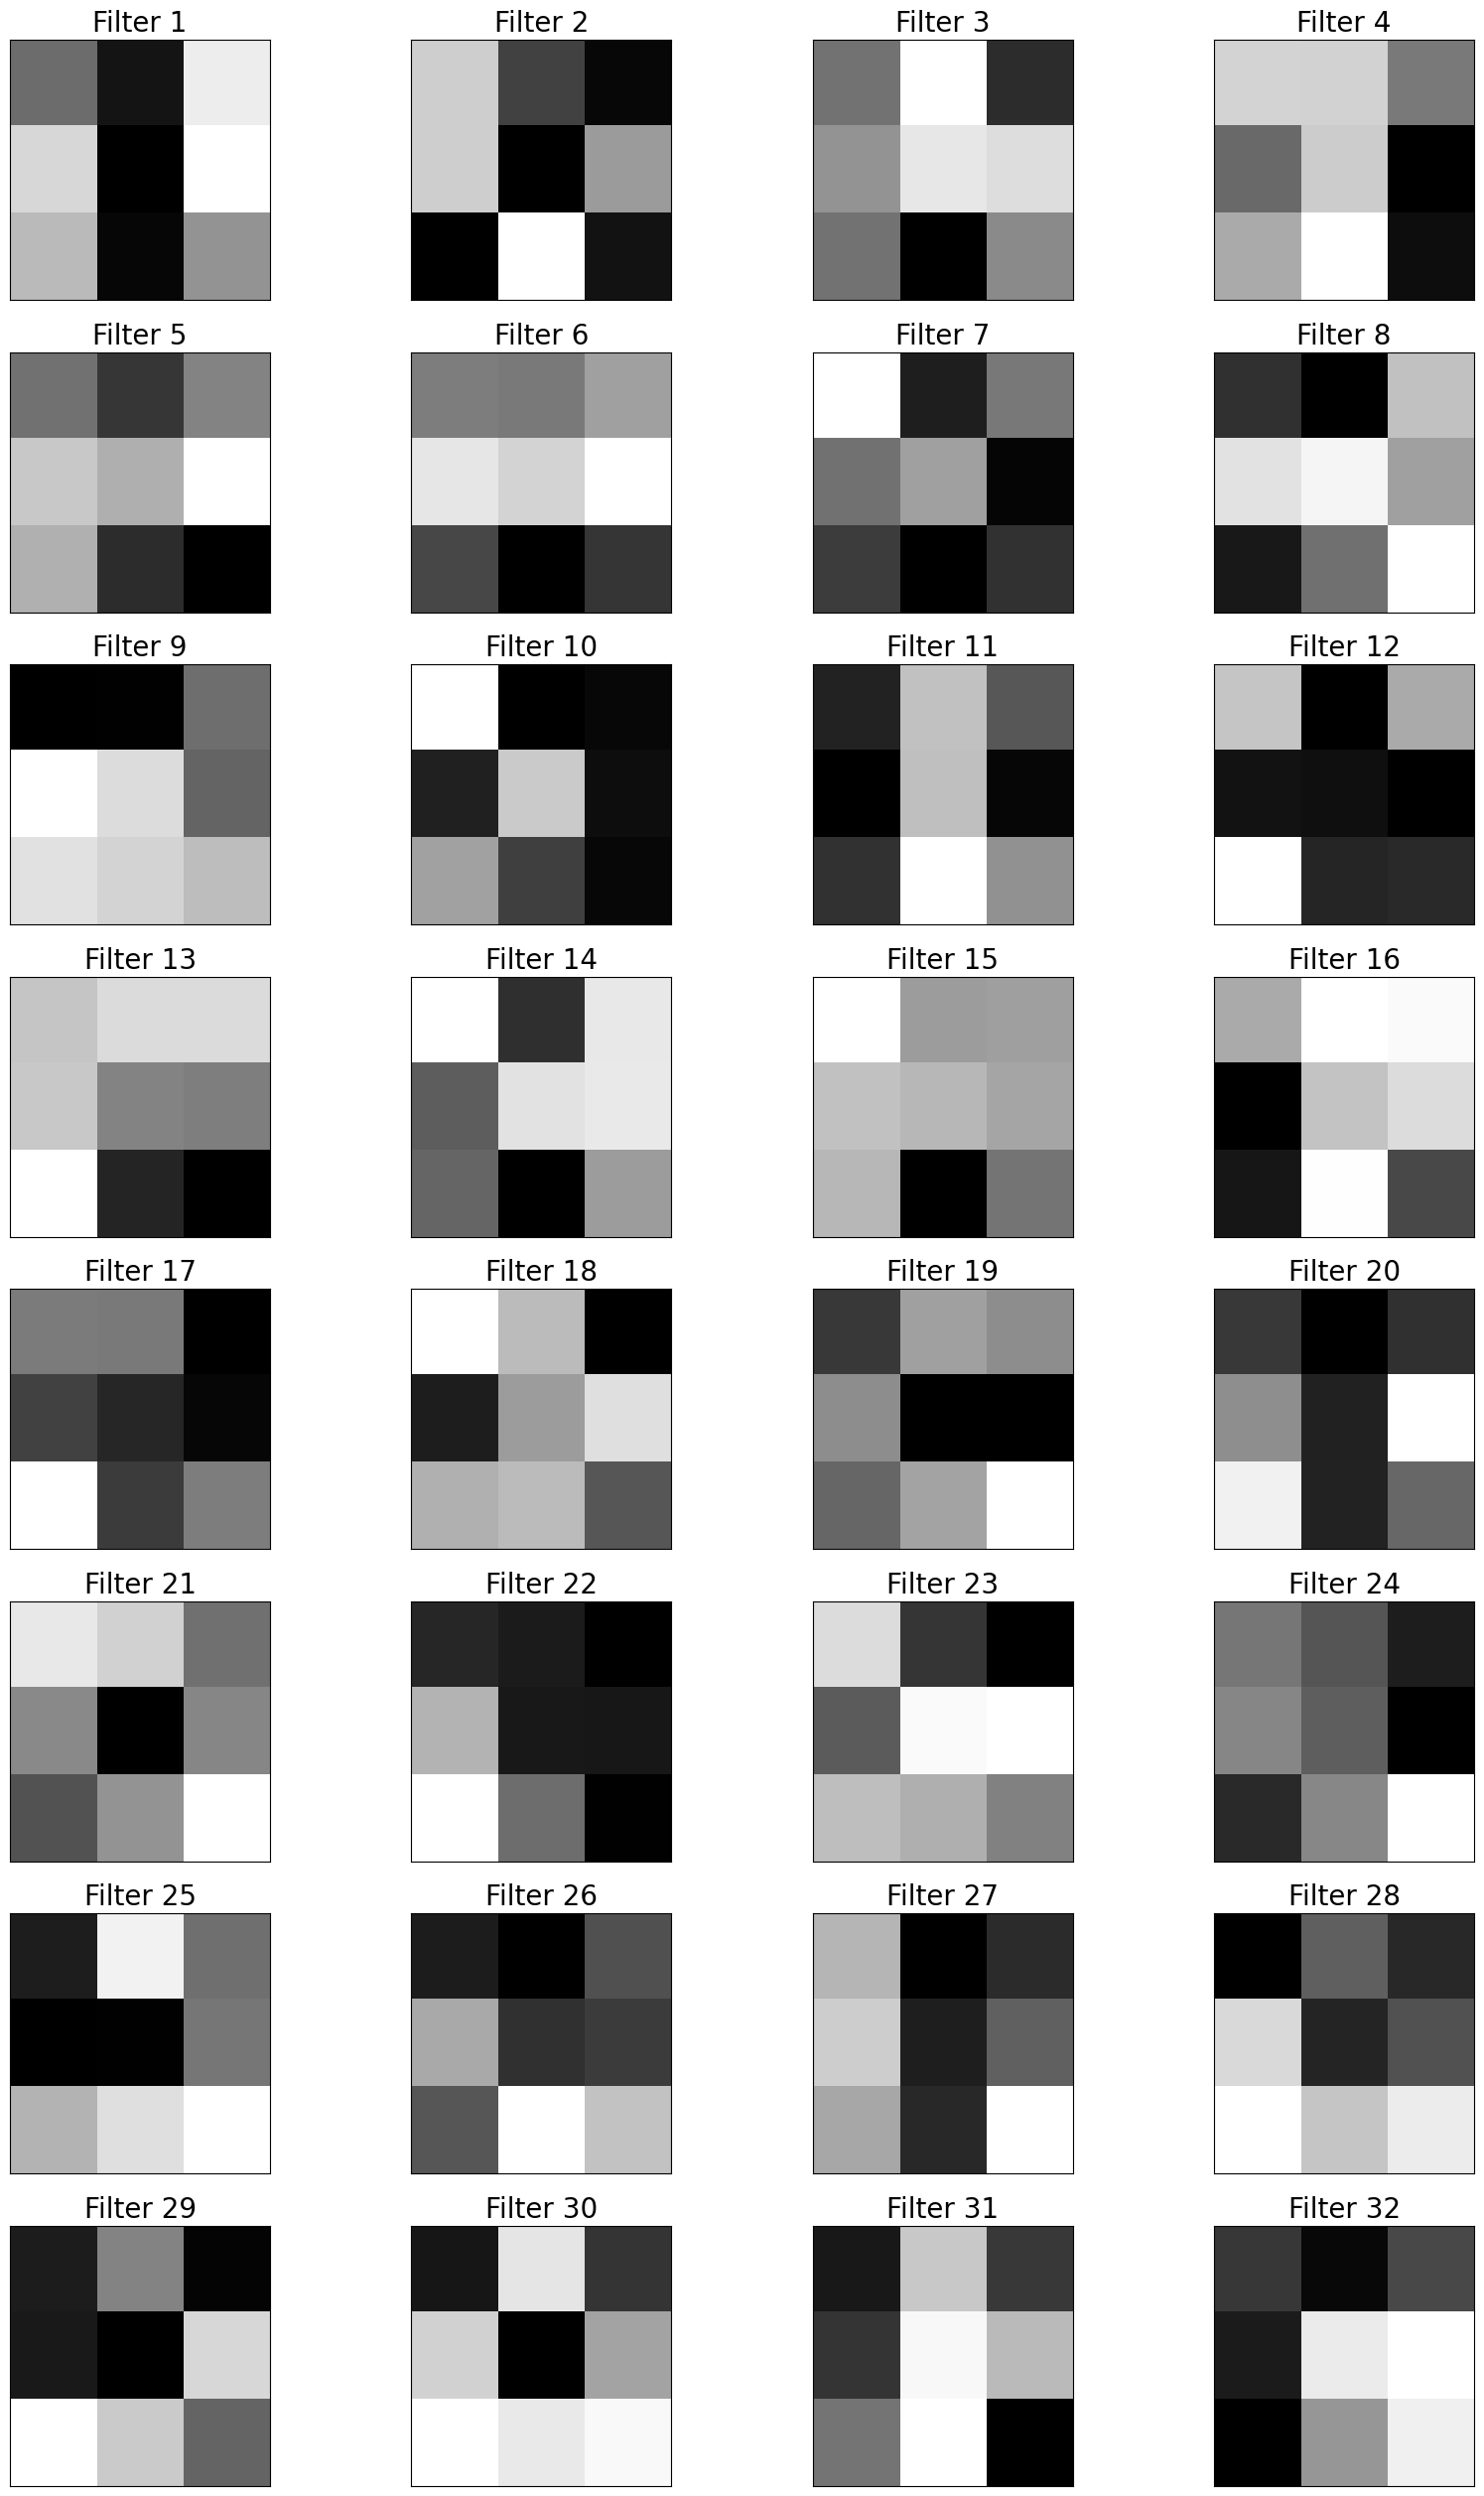

In [ ]:
inspect_weights(CNN_model,layer_name='conv_layer_1')

-------
### Plot Description

This plot shows us the weights for each kernel in the first convolutional layer. Darker regoins signify larger weights suggesting these regions represent patterns which the filter is searching for in the input image.

For example filter 6 appears to be detecing diagonal lines in the input image, this could represent the outline of part of a hand in the input image. Further down in the notebook, I show the input image against the filter and output of the iamge after filter convultion. This will allow for a deeper analysis as to what each filter is trying to detect.

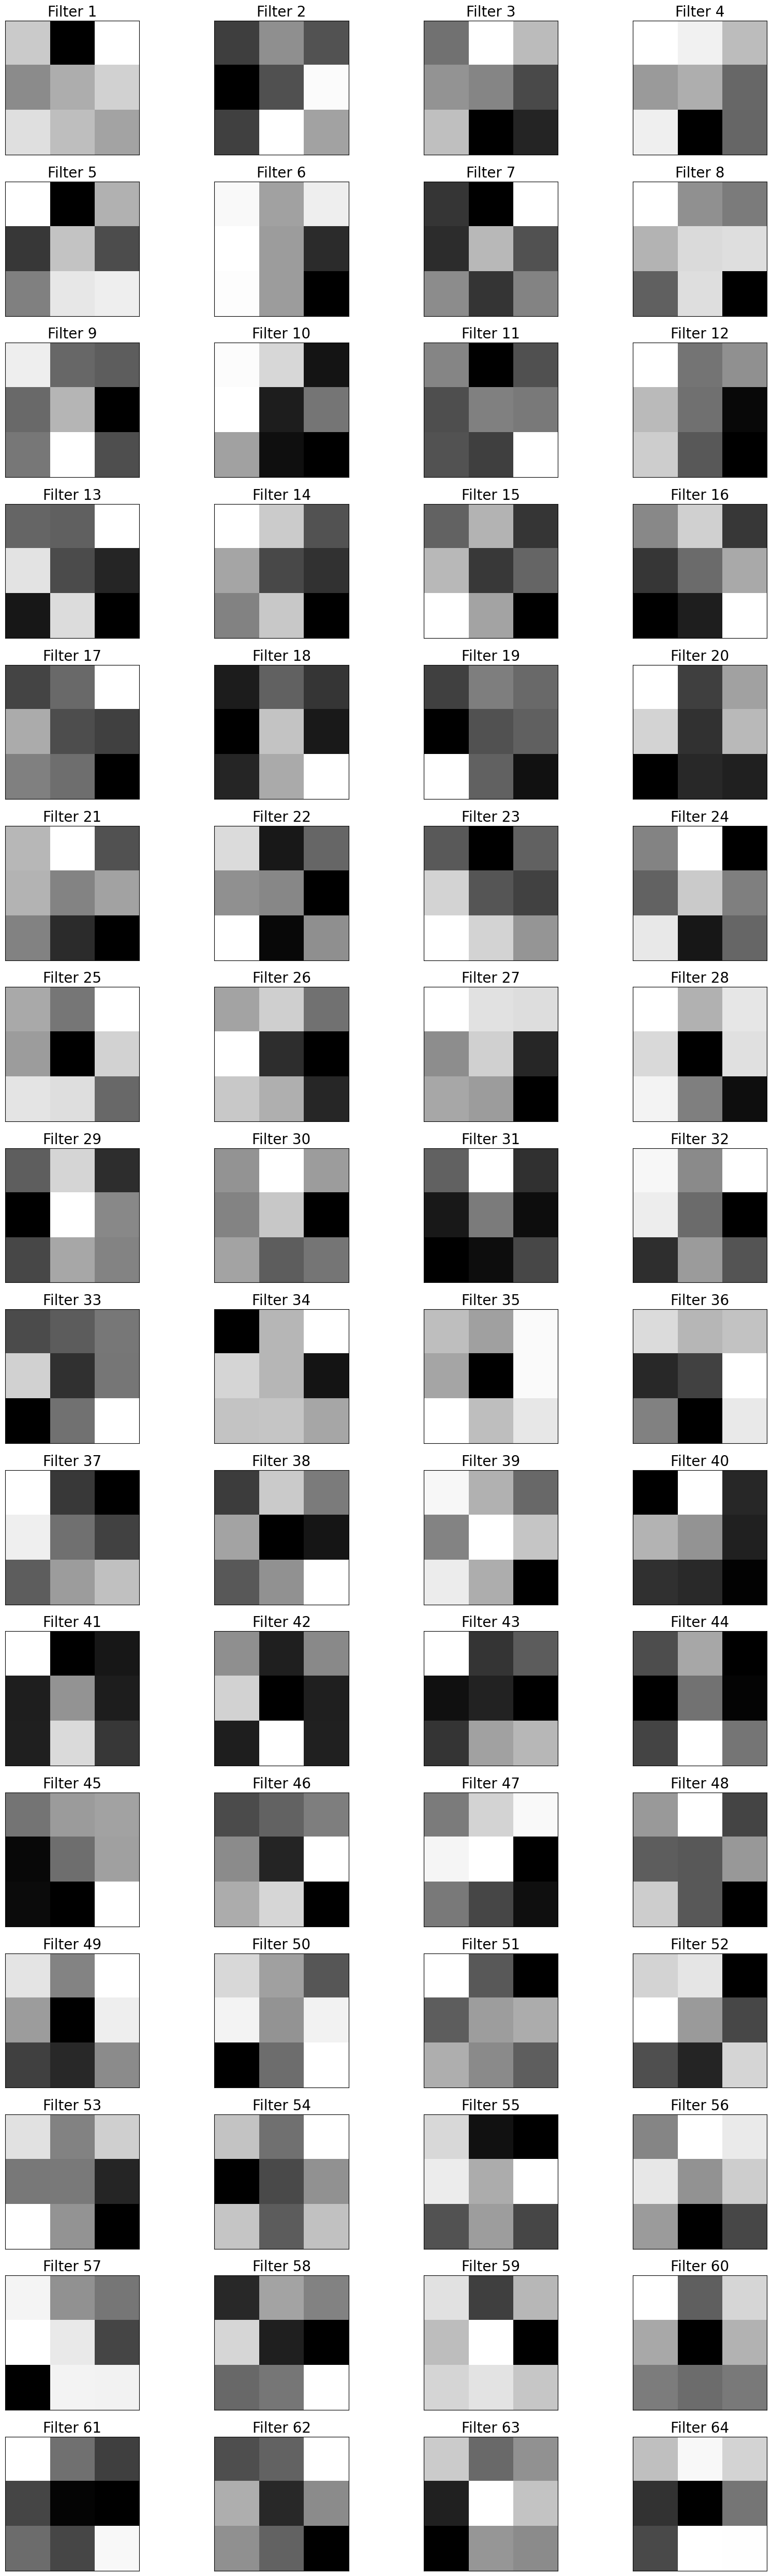

In [ ]:
inspect_weights(CNN_model,layer_name='conv_layer_2')

-------
### Plot Description

This plot shows us the weights for each kernel in the second convolutional layer. As stated above, darker regoins signify larger weights suggesting these regions represent patterns which the filter is searching for in the input image.

Filters in the second layer are looking for more complex patterns in comparison to first layer filters and so are harder to visualise. Filters in the second layer convolve over the output of the first layer which futher adds to the complexity in interpreting patterns.

## Prepping my test image

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

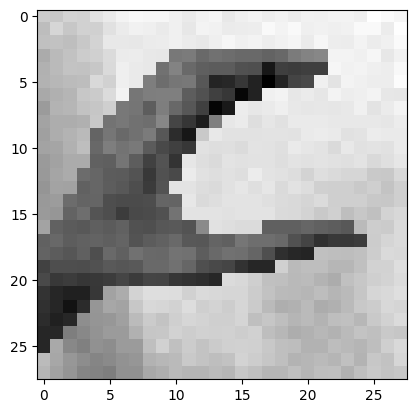

In [ ]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [ ]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)

In [ ]:
image_array.shape

(28, 28, 1)

## Feature map output of first convolutional layer

1/1 [==============================] - 0s 47ms/step


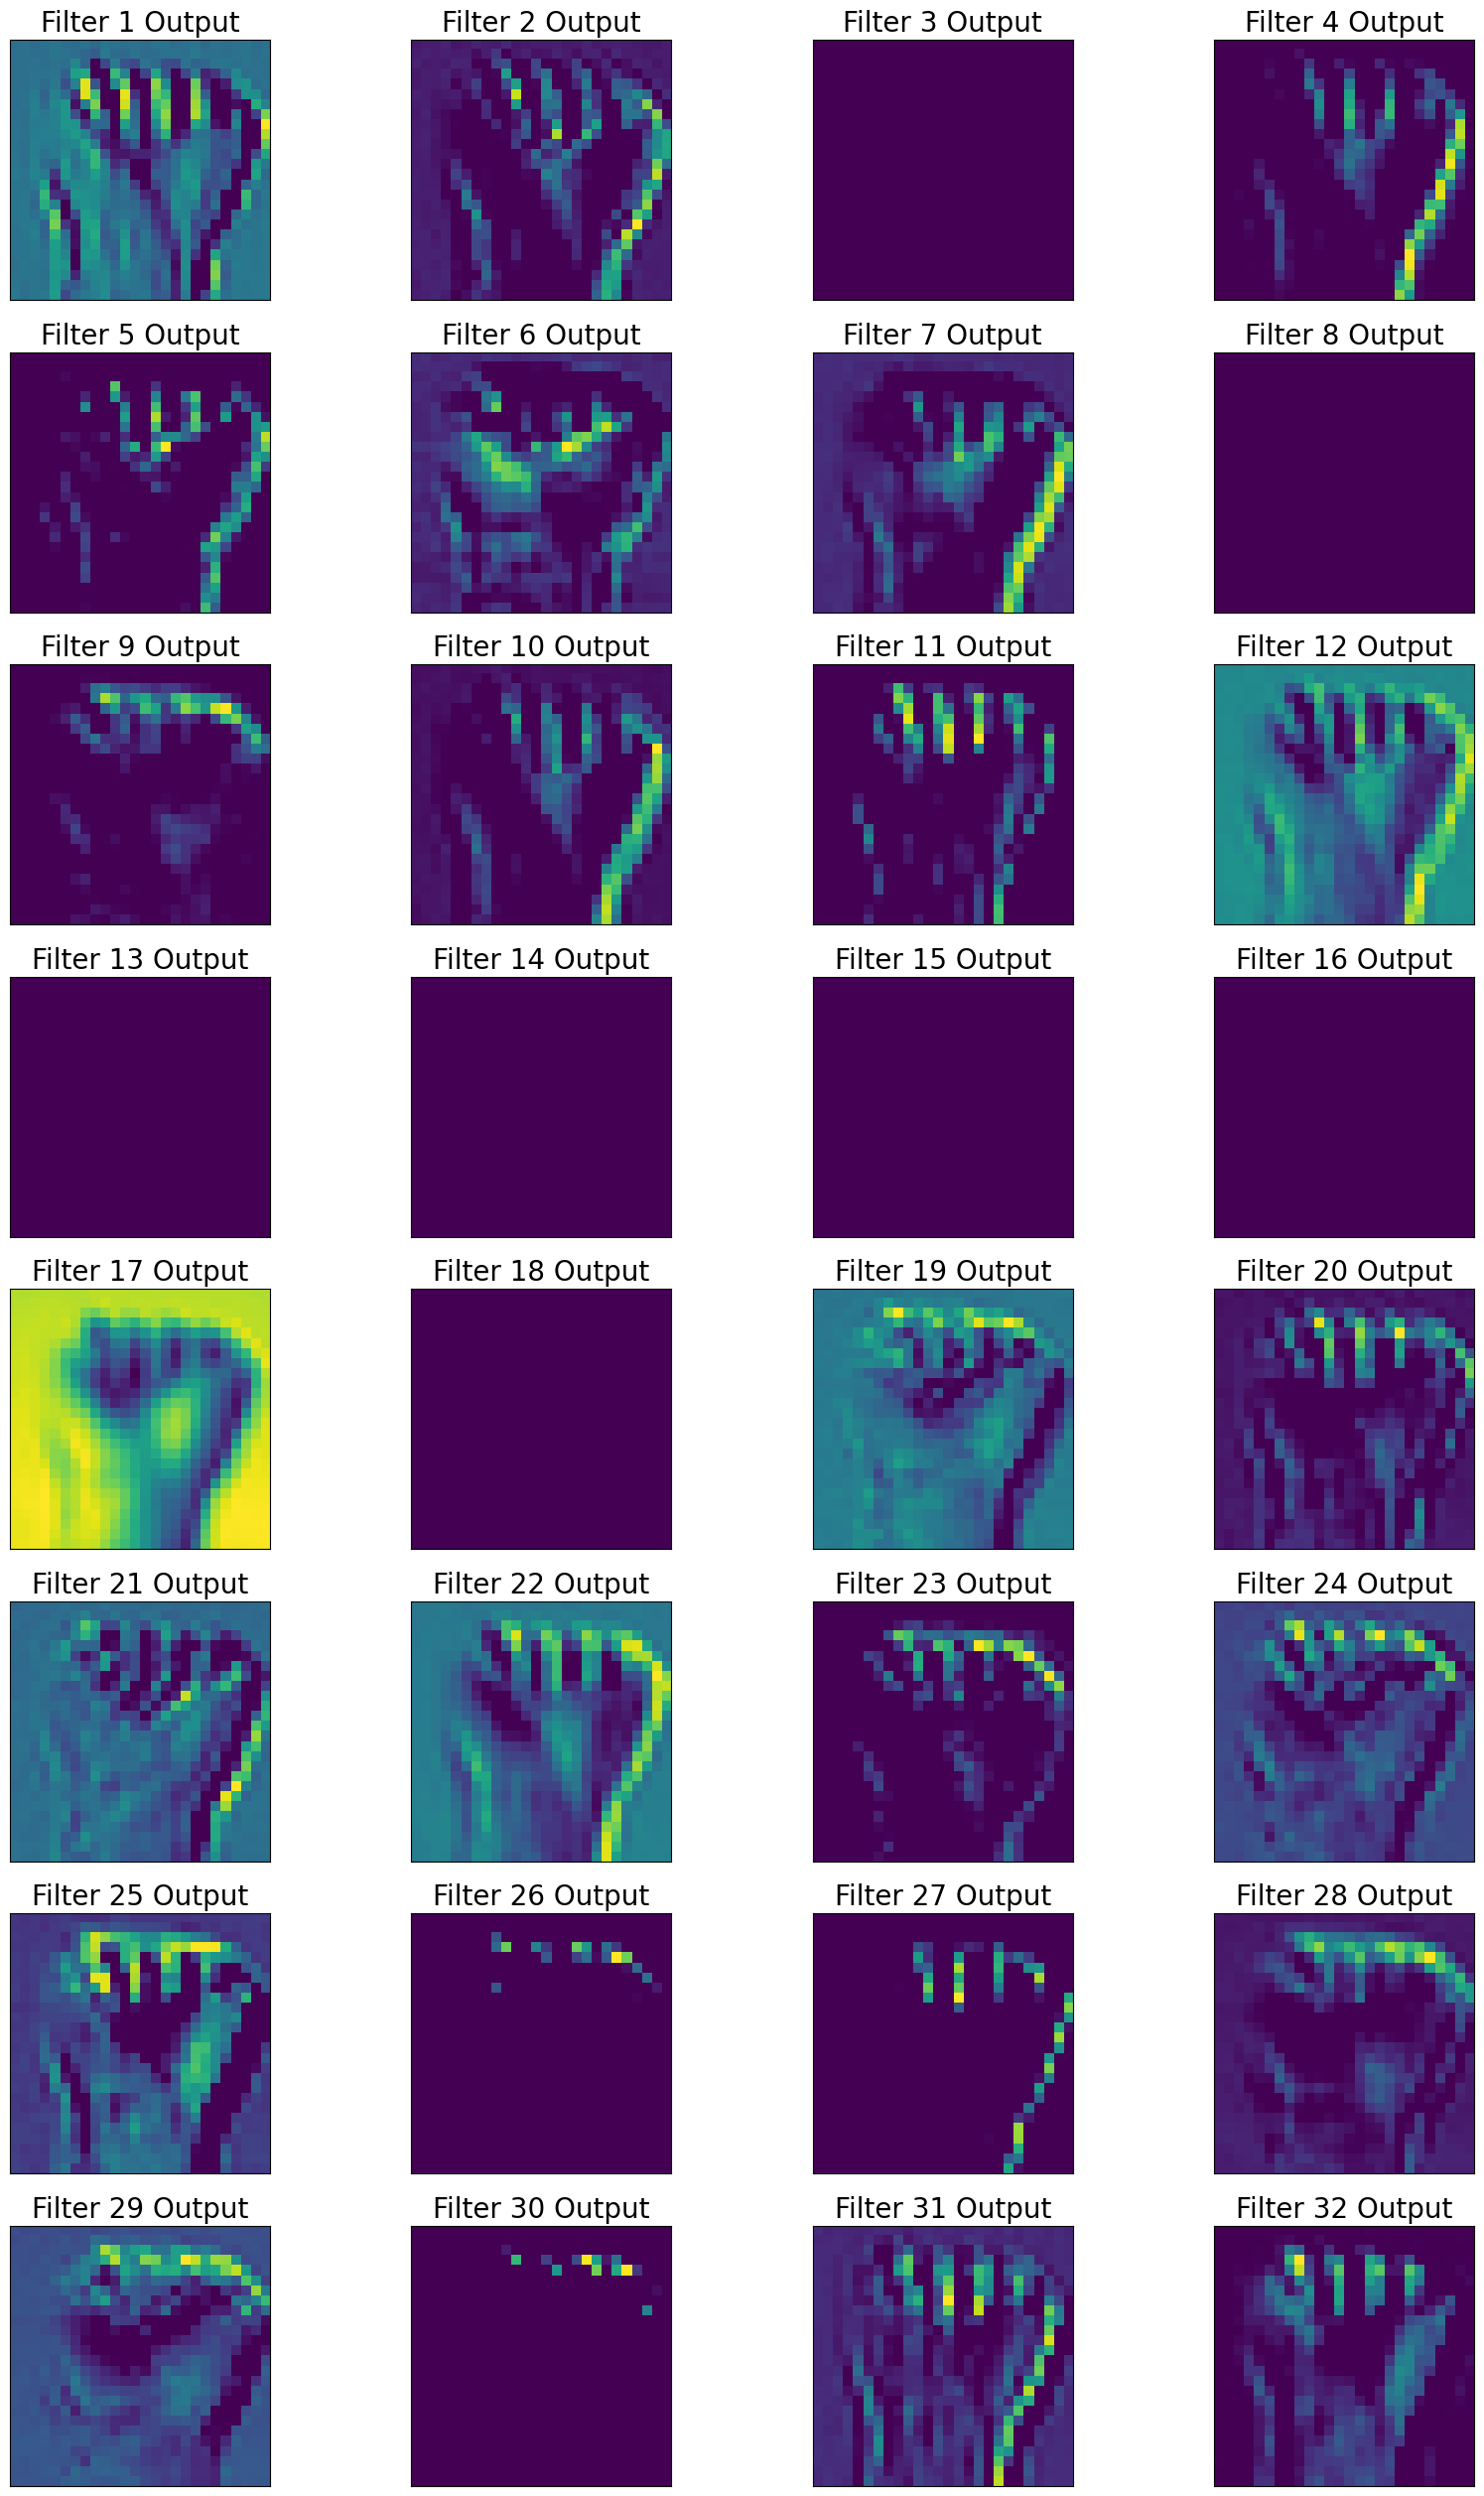

In [ ]:
get_conv_layer_ouput(model = CNN_model, layer_name = 'conv_layer_1', input_img = get_letter_img('a') )
#get_conv_layer_ouput(model = CNN_model, layer_name = 'conv_layer_1', input_img= test_img)

### Plot Description

The feature maps show the resulting image after convolution of the image has occured. In the first convolution layer there are 32 different kernels applied to the input image. The first layer is used to capture low-level patterns such as edges, corners and texture. The output above shows the different outputs (fetaurte maps) after each kernel convoluted over the input image. Lighter regions indicate areas where the kernel has detected relevant features for its given weights. Darker regoins indicatge areas the features between filter and the image are less similar.This provides us this with a better understanding of the result of the first convolution.

## Feature Map output of second convolution layer

1/1 [==============================] - 0s 83ms/step


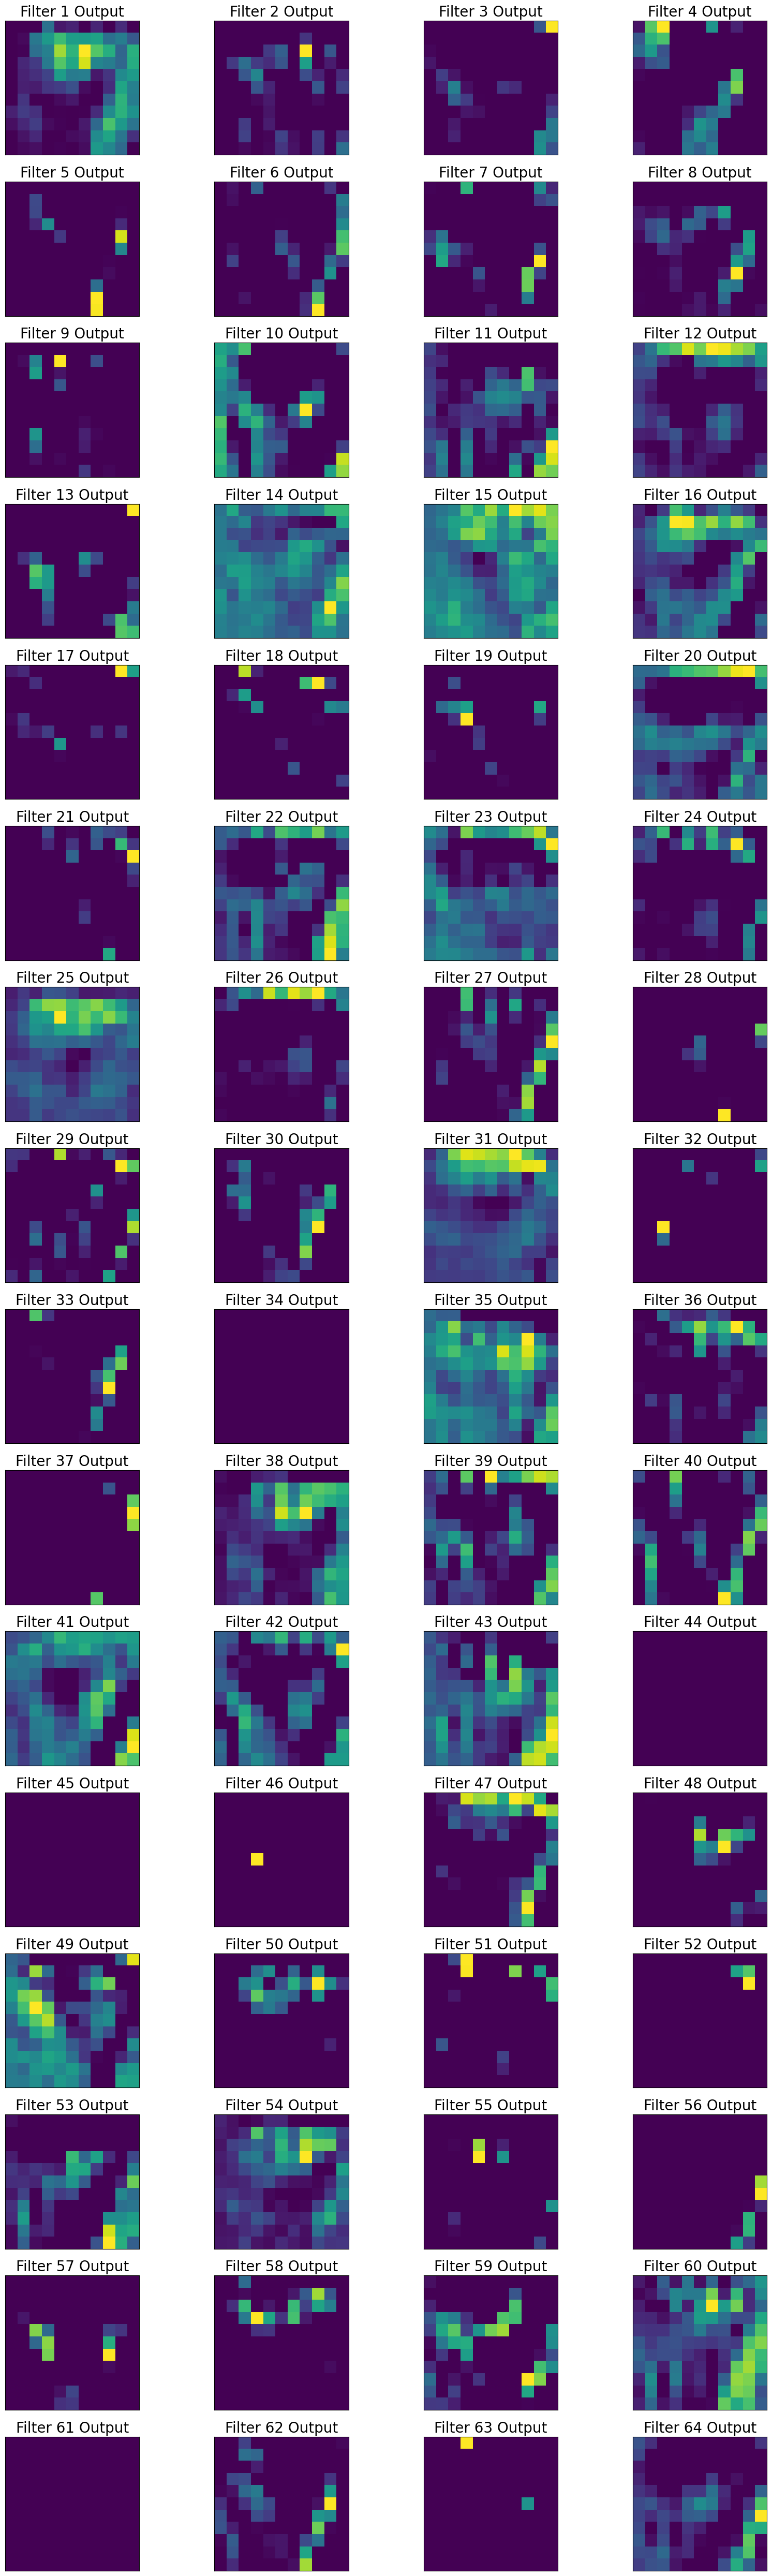

In [ ]:
get_conv_layer_ouput(model = CNN_model, layer_name = 'conv_layer_2', input_img = get_letter_img('a') )

-----------
### Plot Description

 In the second convolution layer there are 64 different kernels applied to the input image. The second layer is used to capture higher level patterns such as combinations of edges or textures. The output above shows the different outputs (fetaurte maps) after each kernel convoluted over the input image. Again, the lighter regions indicate areas where the kernel has detected relevant features for its given weights. This provides us this with a better understanding of the result of the second convolution.

## Output for a given layer and kernel

1/1 [==============================] - 0s 258ms/step


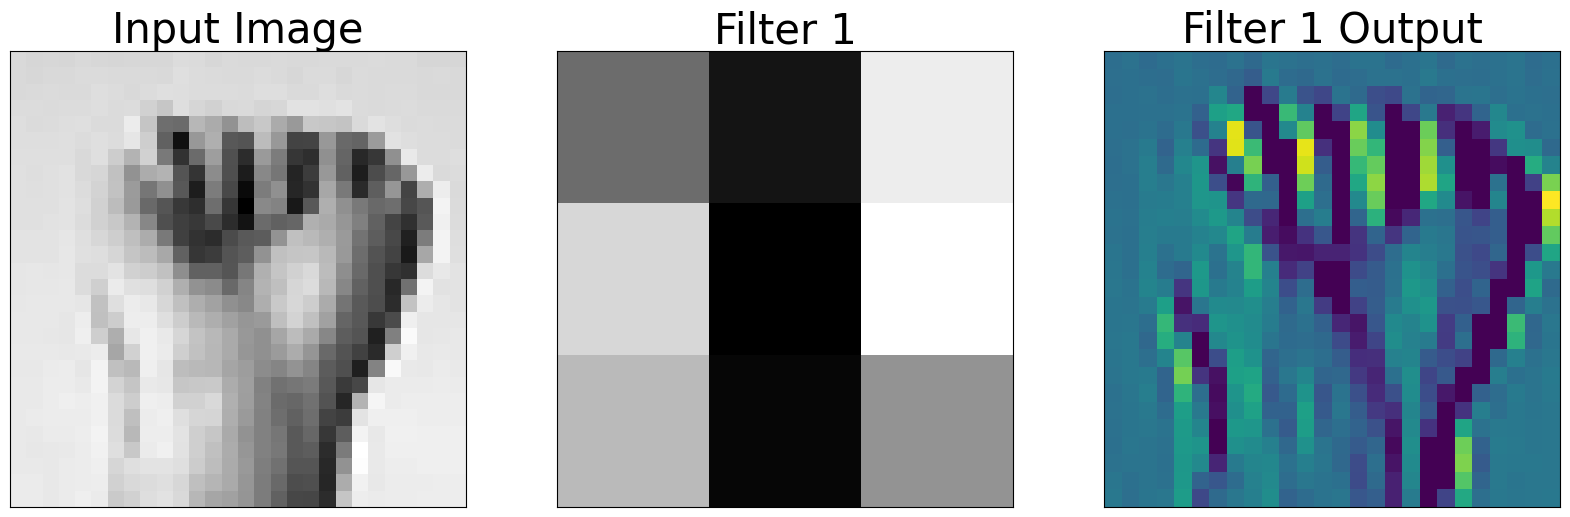

In [ ]:
kernel_with_output(model = CNN_model,test_image = get_letter_img('a'), layer_name = 'conv_layer_1', filter=1)

1/1 [==============================] - 0s 110ms/step


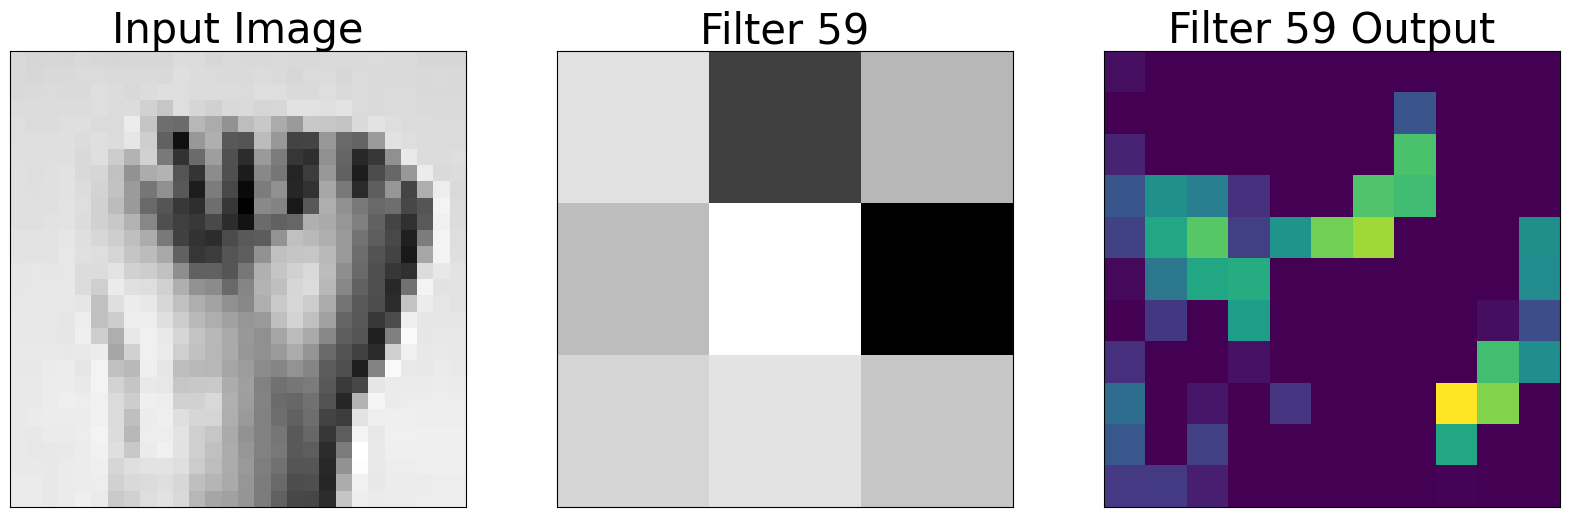

In [ ]:
kernel_with_output(model = CNN_model,test_image = get_letter_img('a'), layer_name = 'conv_layer_2', filter=59)

1/1 [==============================] - 0s 256ms/step


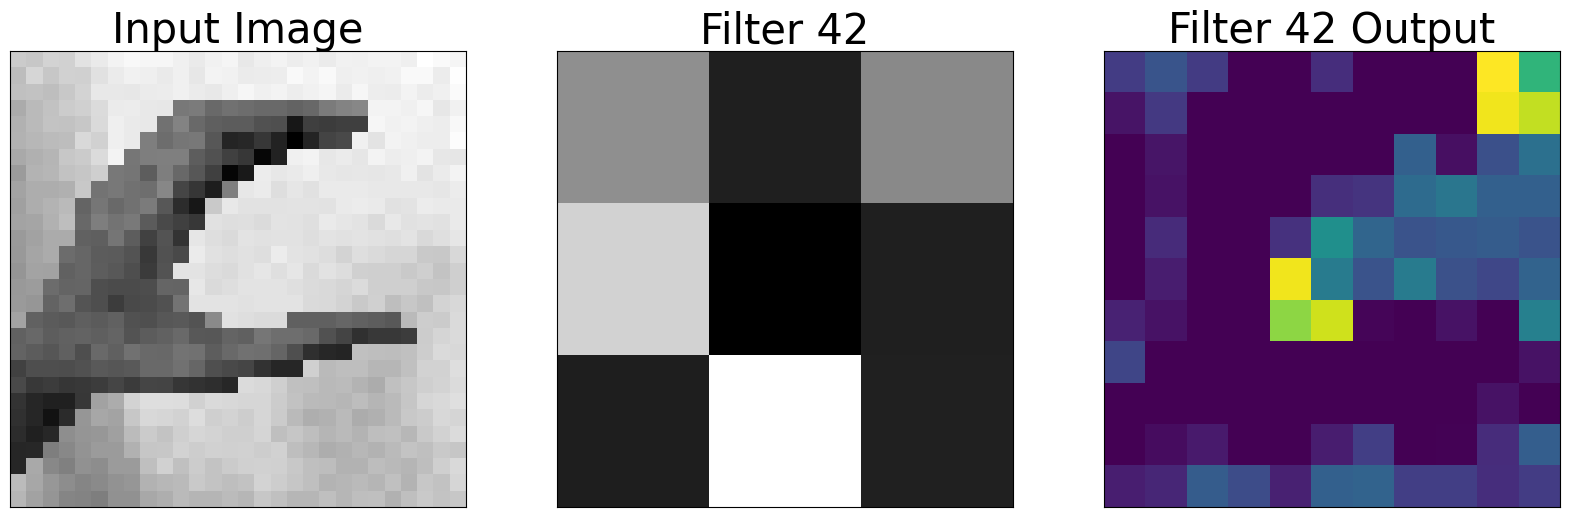

In [ ]:
kernel_with_output(model = CNN_model,test_image = image_array, layer_name = 'conv_layer_2', filter=42)

## Model Evaluation

In [ ]:
score = CNN_model.evaluate(X_val, y_val, verbose=1)
score

217/217 [==============================] - 3s 10ms/step - loss: 0.0037 - accuracy: 0.9993


[0.0036892336793243885, 0.9992780685424805]

### Confusion Matrix

217/217 [==============================] - 2s 10ms/step


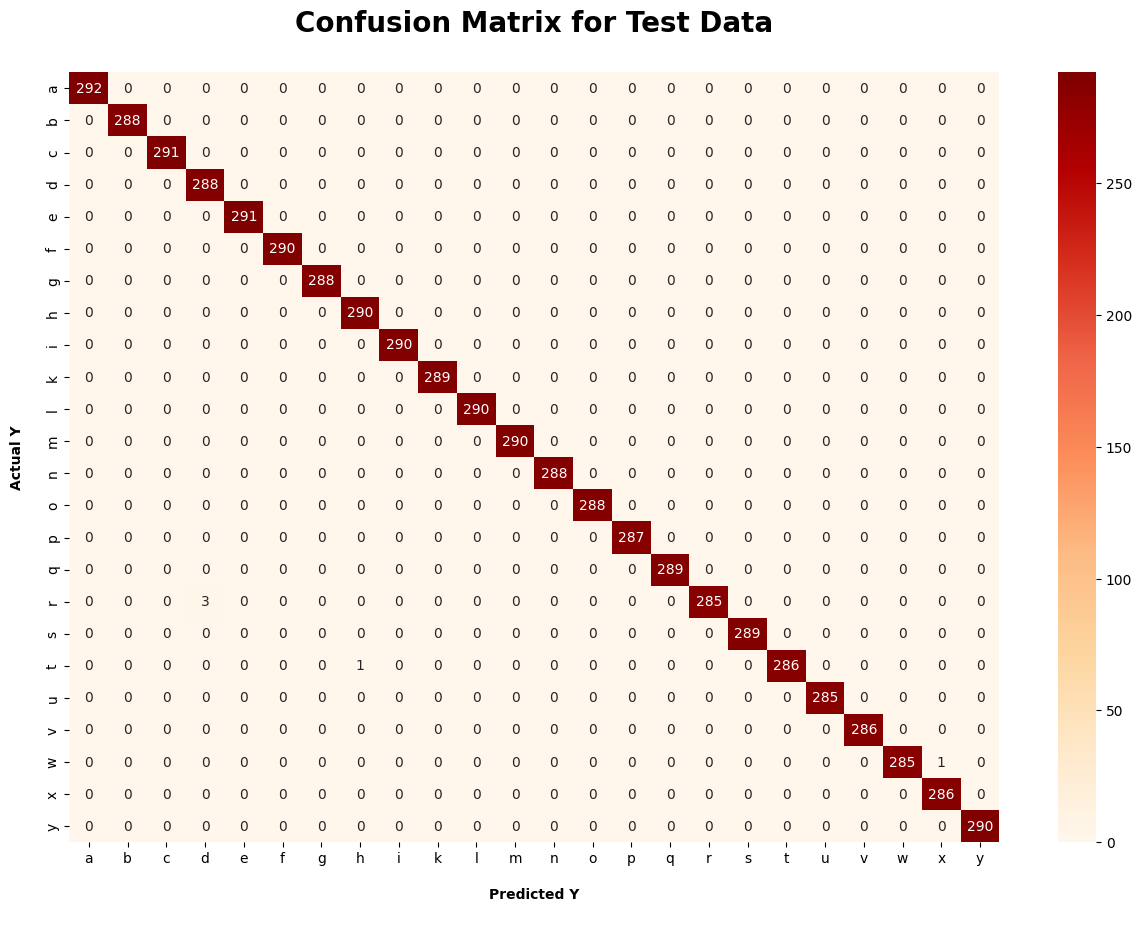

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the predicted labels for each test image.
soft_pred = CNN_model.predict(X_val)
pred_y = np.argmax(soft_pred, axis=1)

# Create the confusion matrix using sklearn
conf_mat = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat,
            annot=True,
            fmt = 'd',
            cmap="OrRd",
           )
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Visualising misclassifications

In [ ]:
incorrect_photos = (y_val != pred_y)
incorrect_photos.sum()

5

In [ ]:
X_val.shape

(6926, 28, 28, 1)

In [ ]:
X_val[incorrect_photos].shape

(5, 28, 28, 1)

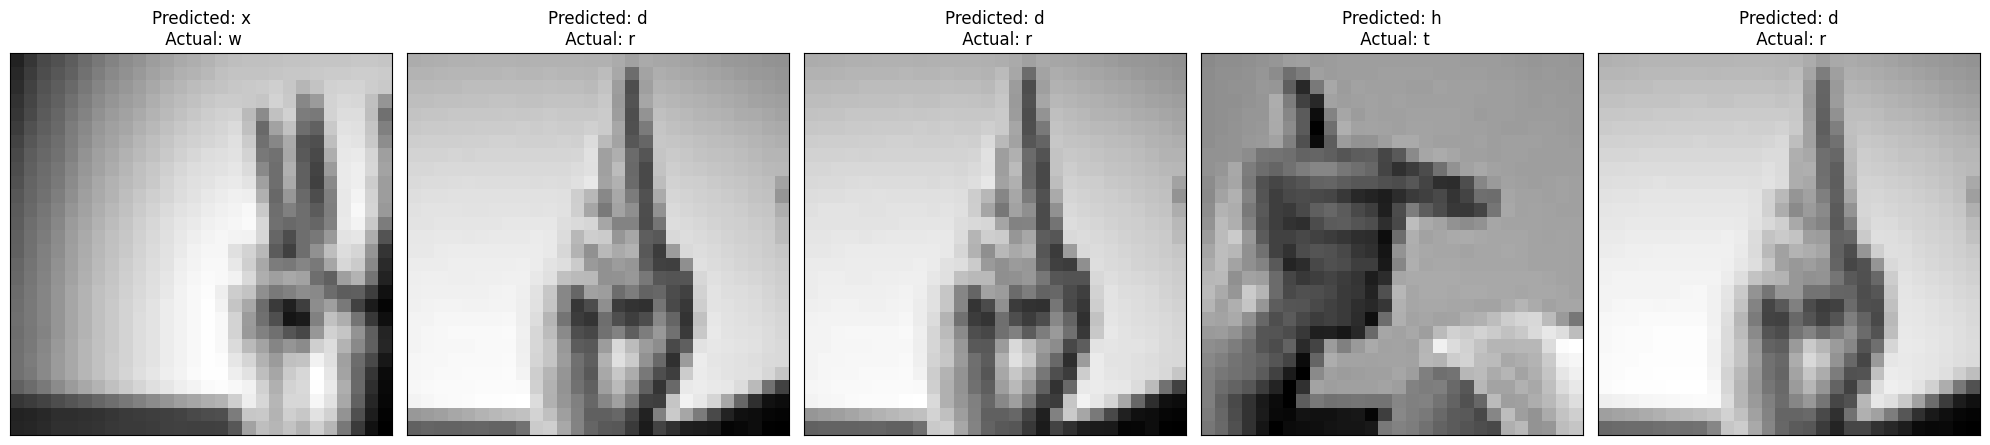

In [ ]:
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos/5)

fig, axes = plt.subplots(rows,5, figsize=(20, 100))

ax = axes.flatten()

for i, image in enumerate(X_val[incorrect_photos]):
    ax[i].imshow(image, cmap='gray')

    # Get predicted label
    p = pred_y[incorrect_photos][i]
    prediction = alphabet[p]

    # Get actual label
    t = y_val[incorrect_photos][i]
    actual = alphabet[t.astype(np.int32)]

    # Set the title of the subplot
    ax[i].set_title(f"Predicted: {prediction}\n Actual: {actual}")

    # Hide the x and y ticks to make
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()


### Comment: Perhaps worth assessing the filters for d and r. see if there is a cross over although misclassifications are very small so more likely to do with quality of input images. For example we can see the images in plot position 1 and 4 are off centered which could explain why misclassification occured.

## Test Image

In [1]:
from keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '/content/drive/My Drive/Colab Notebooks/Capstone/my_files/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

ModuleNotFoundError: No module named 'keras'

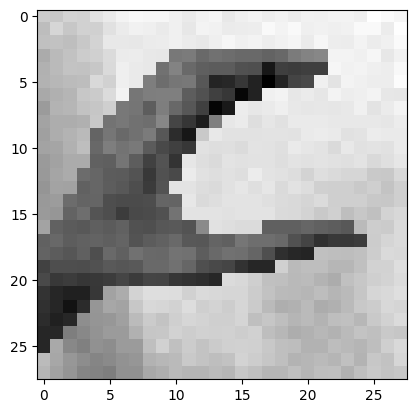

In [ ]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [ ]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)

In [ ]:
image_array.shape

(28, 28, 1)

In [ ]:

# Reshaping to have dimesntions (1,28,28,1) -> to match X_train/X_test dimensions
# 1 as only single image is uploaded
test_img = image_array.reshape(1, image_array.shape[0], image_array.shape[1], image_array.shape[2])

In [ ]:
soft_pred = CNN_model.predict(test_img)
pred_y = np.argmax(soft_pred, axis=1)

1/1 [==============================] - 0s 36ms/step


In [ ]:
pred_y

array([2])

In [ ]:
alphabet[pred_y[0]]

'c'

In [1]:
# TODO:
# Add further insights into the notebook
# To look into misclassifications further
# Add more comments, tidy coding blocks and add summary

## Appendix

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def model_eval_per_letter(letter, y_true, y_pred, y_soft):

  idx = alphabet.index(letter.lower())

  letter_index = np.where(y_pred == idx)
  letter_y_pred = np.where(y_pred[letter_index[0]]==idx,1,0)
  letter_y_test = np.where(y_test[letter_index[0]]==idx,1,0)
  letter_soft_pred = y_soft[:,idx]


  # calculate precision, recall, f1, accuracy scores
  precision = precision_score(letter_y_test, letter_y_pred)
  recall = recall_score(letter_y_test, letter_y_pred)
  f1 = f1_score(letter_y_test, letter_y_pred)
  accuracy = accuracy_score(letter_y_test, letter_y_pred)
  # set colors for bars
  colors = ['thistle', '#6A9BD5', '#8E7CC3', '#543B78']

  # setting up figure to be 1 row of three graphs
  fig, ax = plt.subplots(1,2, figsize=(10,5))

  # 1st metric = Precision, Recall, F1 and Accuracy Score
  ax[0].bar('precision', precision, color=colors[0])
  ax[0].bar('recall', recall, color=colors[1])
  ax[0].bar('f1', f1, color=colors[2])
  ax[0].bar('accuracy', accuracy,color=colors[3])
  ax[0].spines[['top', 'right']].set_visible(False)
  ax[0].set_title('Classification Evaluation Metrics', fontweight='bold')

  # 2nd metric = Confusion Matrix
  cf_matrix = confusion_matrix(y_true = letter_y_test, y_pred = letter_y_pred)
  cf_display = ConfusionMatrixDisplay(cf_matrix)
  cf_display.plot(ax=ax[1],cmap='BuPu',colorbar=False)
  ax[1].set_xlabel('Predicted Value')
  ax[1].set_ylabel('True Value')
  ax[1].set_title('Confusion Matrix', fontweight= 'bold')

  # TODO: figure out error in ROC curve!!
  # # 3rd metric = ROC curve
  # false_pos_rate, true_pos_rate, threshold = roc_curve(letter_y_test,letter_soft_pred) # outputs three arrays: false positive rate, true positve rate and thresholds
  # auc_calc = roc_auc_score(letter_y_test,letter_soft_pred)
  # ax[2].plot(false_pos_rate, true_pos_rate, color='rebeccapurple', label= f'AUC = {auc_calc.round(2)}')
  # ax[2].plot([0,1], [0,1], color = '#6A9BD5', label= 'Baseline (Random Guesses)', linestyle= '--')
  # ax[2].set_xlabel('False Positive Rate')
  # ax[2].set_ylabel('True Positive Rate')
  # ax[2].spines[['top', 'right']].set_visible(False)
  # ax[2].set_title('ROC Curve', fontweight = 'bold')

  # plt.legend()
  plt.show()

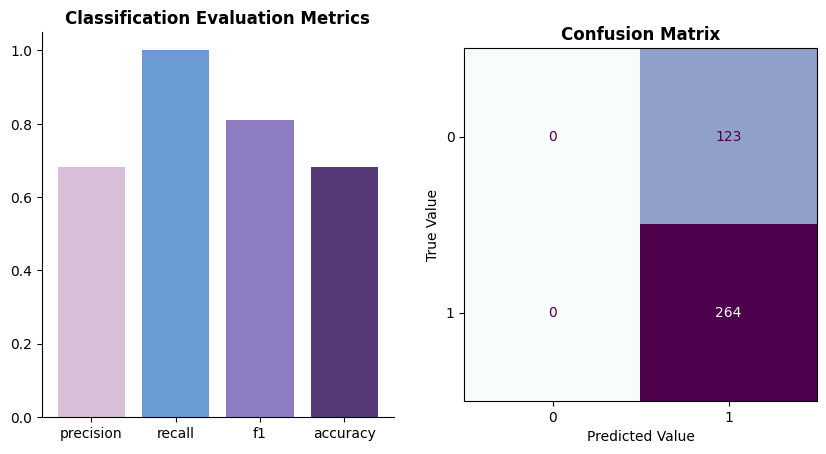

In [ ]:
model_eval_per_letter('w', y_test,pred_y, soft_pred)